In [1]:
# feature importances
from rfpimp import permutation_importances
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# clustering 1d array
from scipy.signal import argrelextrema
from sklearn.neighbors.kde import KernelDensity

# data processing
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# visualization
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# db operations
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.4f}'.format

In [2]:
def connect():
    conn_args = {'check_same_thread': False}
    engine = create_engine('sqlite:///../recommendation.db', connect_args=conn_args)
    return sessionmaker(bind=engine)()

In [3]:
session = connect()
raw = pd.read_sql(con=session.bind, sql='SELECT * FROM movies')
session.close()

#### Intro

In [4]:
df = raw.dropna(subset=['genres', 'runtime'])

In [5]:
df = df.replace('', np.nan)

In [6]:
df.head()

,movie_id,title,primary_title,genres,kind,description,image_url,average_rating,num_votes,start_year,end_year,is_adult,runtime,trailer_id
0,tt0111161,The Shawshank Redemption,The Shawshank Redemption,Drama,movie,The Shawshank Redemption is a movie starring T...,https://m.media-amazon.com/images/M/MV5BMDFkYT...,9.3000,2169261,1994.0000,nan,0,142.0000,vi3877612057
1,tt0468569,The Dark Knight,The Dark Knight,"Action,Crime,Drama",movie,The Dark Knight is a movie starring Christian ...,https://m.media-amazon.com/images/M/MV5BMTMxNT...,9.0000,2153207,2008.0000,nan,0,152.0000,vi324468761
2,tt1375666,Inception,Inception,"Action,Adventure,Sci-Fi",movie,Inception is a movie starring Leonardo DiCapri...,https://m.media-amazon.com/images/M/MV5BMjAxMz...,8.8000,1901350,2010.0000,nan,0,148.0000,vi4219471385
3,tt0137523,Fight Club,Fight Club,Drama,movie,"Fight Club is a movie starring Brad Pitt, Edwa...",https://m.media-amazon.com/images/M/MV5BMmEzNT...,8.8000,1732978,1999.0000,nan,0,139.0000,vi781228825
4,tt0944947,Game of Thrones,Game of Thrones,"Action,Adventure,Drama",tvSeries,Game of Thrones is a TV series starring Emilia...,https://m.media-amazon.com/images/M/MV5BMjA5Nz...,9.4000,1614711,2011.0000,2019.0000,0,57.0000,vi3672620057


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
average_rating,100000.0000,6.4398,1.1846,1.0000,5.8000,6.6000,7.2000,10.0000
num_votes,100000.0000,8710.6466,48858.7830,110.0000,307.0000,638.0000,2048.0000,2169261.0000
start_year,99999.0000,1995.0795,23.8104,1874.0000,1984.0000,2004.0000,2013.0000,2019.0000
end_year,7373.0000,2003.0429,14.2980,1953.0000,1996.0000,2007.0000,2014.0000,2021.0000
is_adult,100000.0000,0.0014,0.0369,0.0000,0.0000,0.0000,0.0000,1.0000
runtime,95544.0000,90.6298,54.2087,0.0000,78.0000,92.0000,106.0000,5220.0000


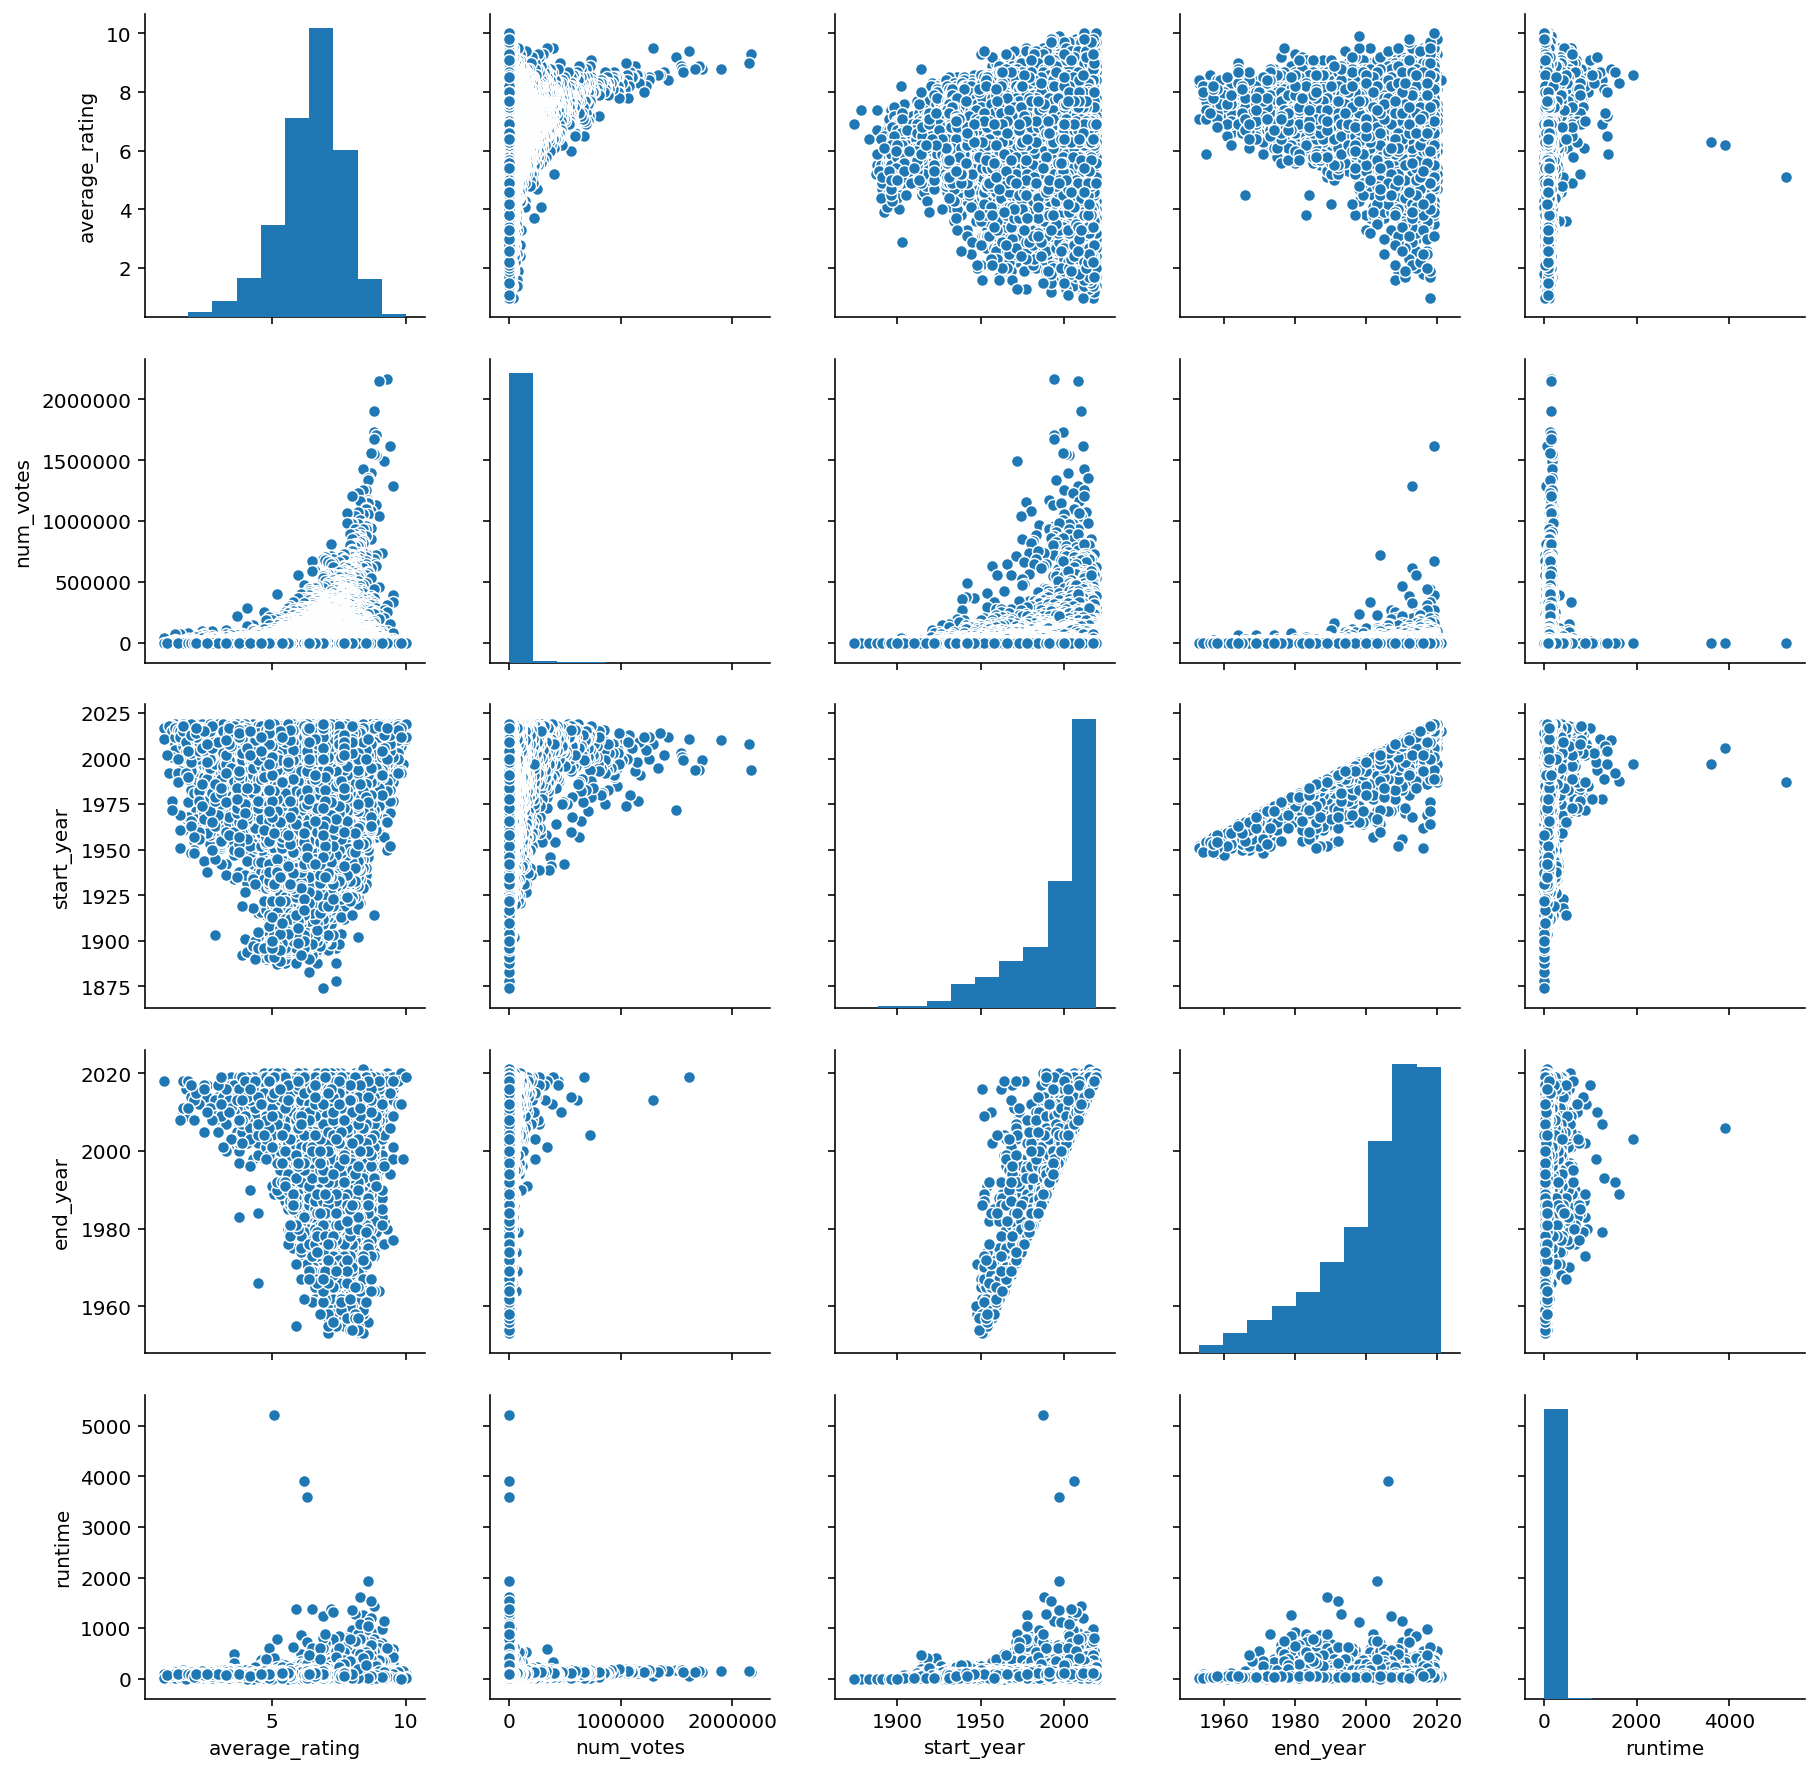

In [8]:
sns.pairplot(df.drop('is_adult', axis=1));

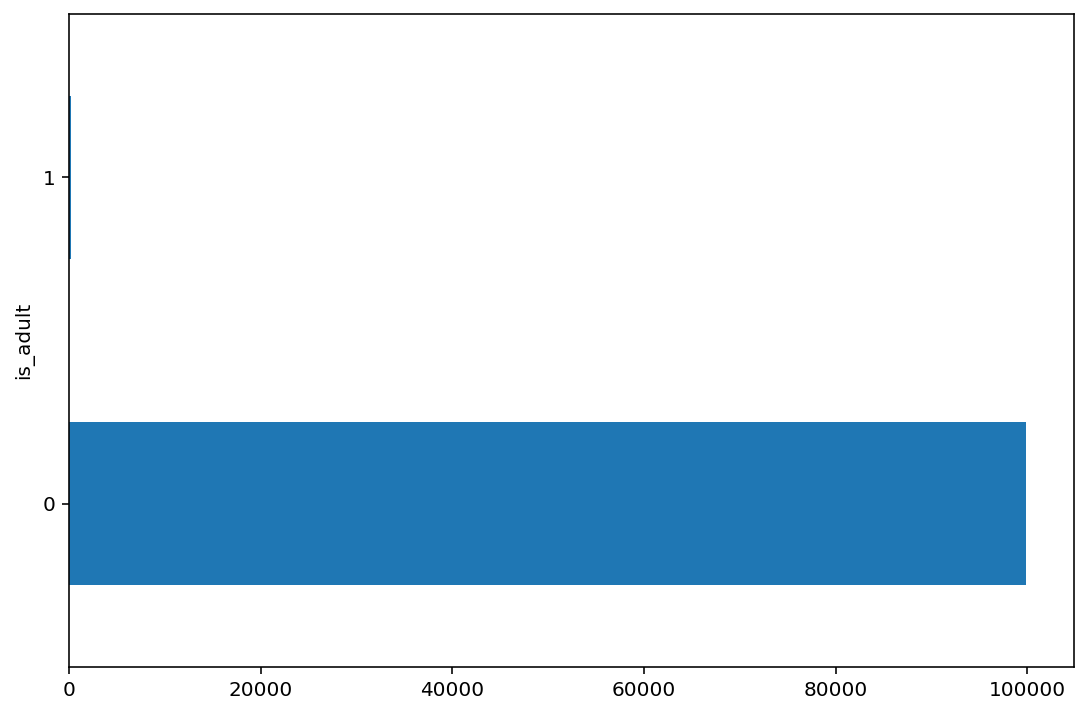

In [9]:
df.groupby('is_adult').size().plot.barh(figsize=(9, 6));

#### Preprocessing

In [10]:
df.isnull().sum()

movie_id              0
title                 0
primary_title         0
genres               80
kind                  0
description        3906
image_url           642
average_rating        0
num_votes             0
start_year            1
end_year          92627
is_adult              0
runtime            4456
trailer_id        70254
dtype: int64

- Delete the `end_year` variable because it contains too many missing values

In [11]:
df = df.drop('end_year', axis=1)

In [12]:
cols = [
    'title',
    'kind',
    'average_rating',
    'num_votes',
    'start_year',
    'runtime',
    'genres',
]

- Convert string to int with label encoder

In [13]:
le = LabelEncoder()
dataset = df[cols].dropna().copy()
dataset['kind'] = le.fit_transform(dataset['kind'])

In [14]:
dataset.head()

,title,kind,average_rating,num_votes,start_year,runtime,genres
0,The Shawshank Redemption,0,9.3000,2169261,1994.0000,142.0000,Drama
1,The Dark Knight,0,9.0000,2153207,2008.0000,152.0000,"Action,Crime,Drama"
2,Inception,0,8.8000,1901350,2010.0000,148.0000,"Action,Adventure,Sci-Fi"
3,Fight Club,0,8.8000,1732978,1999.0000,139.0000,Drama
4,Game of Thrones,4,9.4000,1614711,2011.0000,57.0000,"Action,Adventure,Drama"


#### Feature Importances

In [15]:
def imp_df(column_names, importances):
    data = {
        'Feature': column_names,
        'Importance': importances,
    }
    df = pd.DataFrame(data) \
        .set_index('Feature') \
        .sort_values('Importance', ascending=False)
    
    return df

In [16]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

In [17]:
def drop_col_feat_imp(model, X_train, y_train, random_state=42):
    model_clone = clone(model)
    model_clone.random_state = random_state
    
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    
    importances = []
    
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis=1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis=1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    return imp_df(X_train.columns, importances)

In [18]:
X = dataset.drop(['average_rating', 'title', 'genres'], axis=1)
y = dataset['average_rating']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=0)

In [20]:
rf = RandomForestRegressor().fit(X_train, y_train)

In [21]:
rf.score(X_train, y_train) 

0.8435677657402854

In [22]:
rf.score(X_test, y_test)

0.11067733333394947

- Features importances by random forests

In [23]:
imp_df(X.columns, rf.feature_importances_)

,Importance
Feature,
num_votes,0.4491
runtime,0.2976
start_year,0.2215
kind,0.0317


- Feature importances with permutation
- See `references` for detailed information about `permutation_importances`

In [24]:
permutation_importances(rf, X_train, y_train, r2)

,Importance
Feature,
runtime,0.9482
num_votes,0.8687
start_year,0.7104
kind,0.3200


- Make `feature importances` comparisons by deleting columns one by one

In [25]:
drop_col_feat_imp(rf, X_train, y_train)

,Importance
Feature,
num_votes,0.5031
runtime,0.0975
start_year,0.0970
kind,0.0071


#### Scoring

In [26]:
dataset['score'] = (
    0.5031 * dataset['num_votes'] + 0.0975 * dataset['runtime'] + 
    0.0970 * dataset['start_year'] + 0.0071 * dataset['kind']
)

In [27]:
dataset = dataset.reset_index(drop=True)

In [28]:
dataset.sort_values(by='score', ascending=False).head(20)

,title,kind,average_rating,num_votes,start_year,runtime,genres,score
0,The Shawshank Redemption,0,9.3000,2169261,1994.0000,142.0000,Drama,1091562.4721
1,The Dark Knight,0,9.0000,2153207,2008.0000,152.0000,"Action,Crime,Drama",1083488.0377
2,Inception,0,8.8000,1901350,2010.0000,148.0000,"Action,Adventure,Sci-Fi",956778.5850
3,Fight Club,0,8.8000,1732978,1999.0000,139.0000,Drama,872068.6873
5,Pulp Fiction,0,8.9000,1703225,1994.0000,154.0000,"Crime,Drama",857100.9305
6,Forrest Gump,0,8.8000,1670810,1994.0000,142.0000,"Drama,Romance",840791.7740
4,Game of Thrones,4,9.4000,1614711,2011.0000,57.0000,"Action,Adventure,Drama",812561.7570
10,The Matrix,0,8.7000,1561679,1999.0000,136.0000,"Action,Sci-Fi",785887.8679
9,The Lord of the Rings: The Fellowship of the Ring,0,8.8000,1555124,2001.0000,178.0000,"Adventure,Drama,Fantasy",782594.3364
8,The Lord of the Rings: The Return of the King,0,8.9000,1543231,2003.0000,201.0000,"Adventure,Drama,Fantasy",776613.4046


In [29]:
dataset['score'].describe().T

count     95492.0000
mean       4779.7425
std       25137.9826
min         251.0067
25%         361.0729
50%         539.4249
75%        1310.4544
max     1091562.4721
Name: score, dtype: float64

#### Clustering

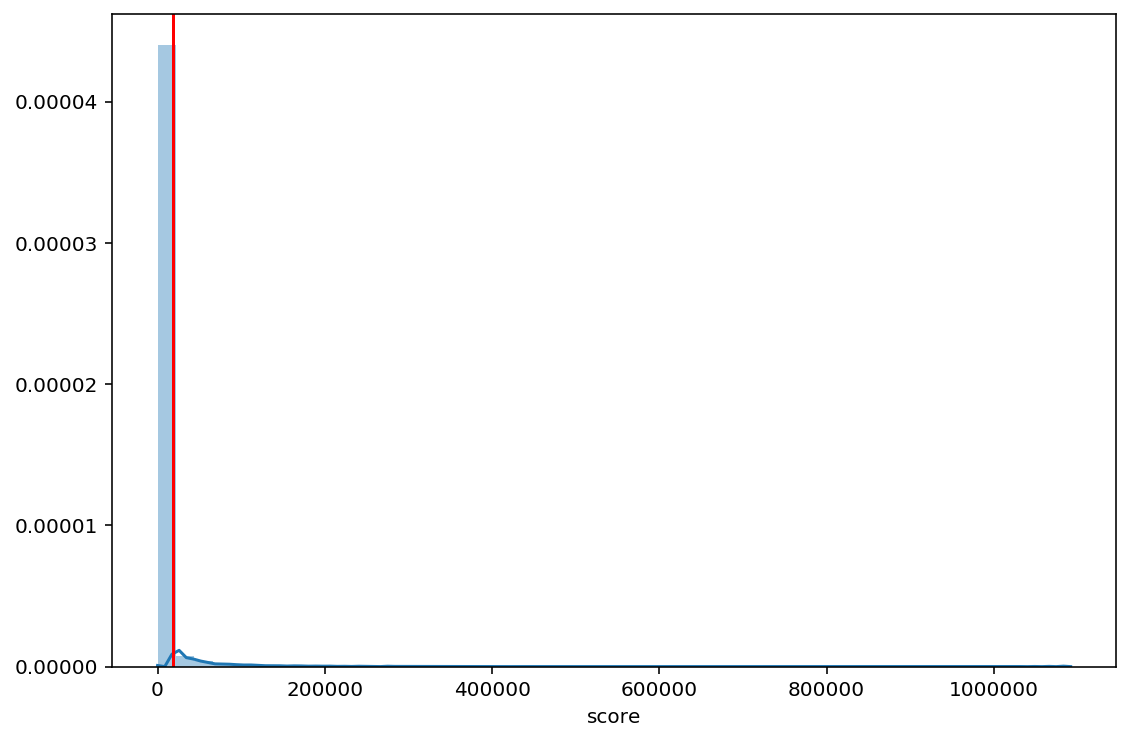

In [30]:
plt.figure(figsize=(9, 6))
sns.distplot(dataset['score'])
plt.axvline(18000, color='r');

- If I don't set the 18,000 limit, it collects all the values up to 18,000 in a cluster
- You can try if you want

In [31]:
vals = dataset['score'].values.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(vals)

s = np.linspace(250, 18000)
e = kde.score_samples(s.reshape(-1,1))

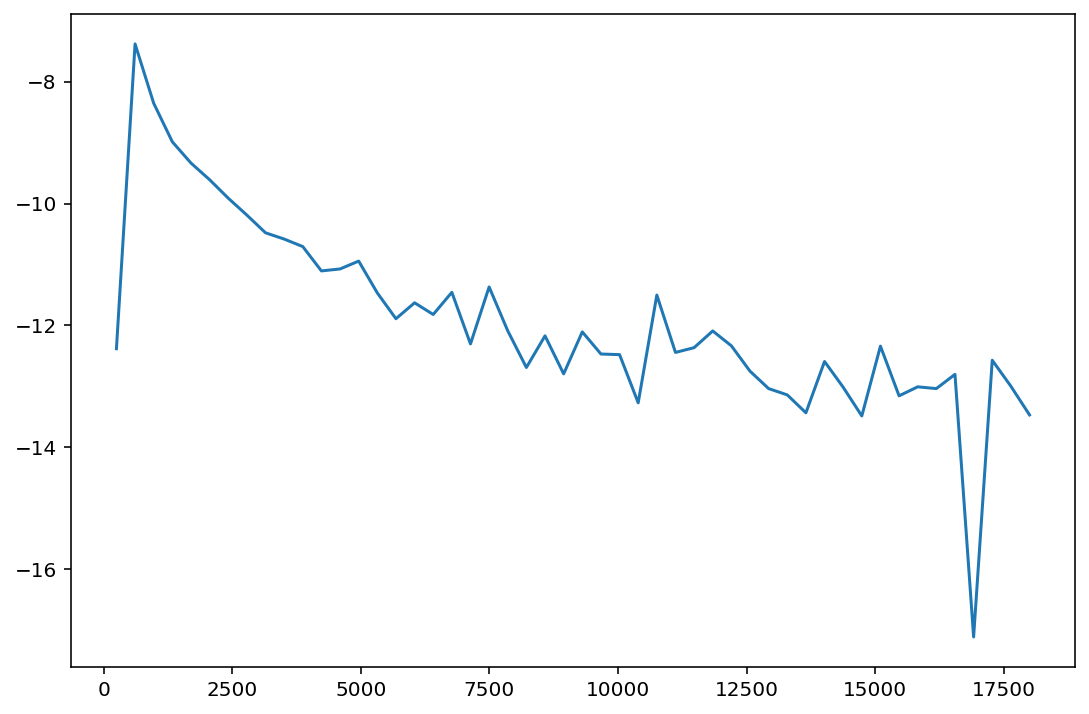

In [32]:
plt.figure(figsize=(9, 6))
plt.plot(s, e);

- Find min-max points of clusters
- Concat min points (`s[mi]`) and max points (`s[ma]`)
- Sort points
- And assign clusters

In [33]:
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]

In [34]:
points = np.concatenate((s[mi], s[ma]), axis=0)
buckets = []

for point in points:
    buckets.append(point)

In [35]:
buckets = np.array(buckets)
buckets.sort()

In [36]:
dataset['cluster'] = buckets.searchsorted(dataset.score)

In [37]:
dataset.groupby('cluster').size()

cluster
0     52700
1     31848
2      1060
3       759
4       345
5       299
6       318
7       240
8       234
9       401
10      210
11      183
12      170
13      468
14      142
15      123
16      222
17      470
18       83
19      149
20       84
21       91
22       78
23       65
24       65
25       60
26       75
27     4550
dtype: int64

#### Recommendation

- Tf-idf vectorizer for finding similarity of genres
- Linear kernel creates an NxN matrix with similarities between movies

In [38]:
tfidf_vectorizer = TfidfVectorizer()
matrix = tfidf_vectorizer.fit_transform(dataset['genres'])

In [39]:
def get_recommendations(movie_index):
    print(dataset.iloc[movie_index])
    
    kernel = linear_kernel(matrix[movie_index], matrix)
    sim_scores = list(enumerate(kernel[0]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    indexes = [i[0] for i in sim_scores if i[0] != movie_index and i[1] > .5]
    
    cond1 = (dataset.index.isin(indexes))
    cond2 = (dataset.cluster == dataset.iloc[movie_index]['cluster'])
    cond3 = (dataset.kind == dataset.iloc[movie_index]['kind'])
    
    selected = dataset.loc[cond1 & cond2 & cond3] \
        .sort_values(by='score', ascending=False).head(20)
    display(selected)

In [40]:
get_recommendations(0)

title             The Shawshank Redemption
kind                                     0
average_rating                      9.3000
num_votes                          2169261
start_year                       1994.0000
runtime                           142.0000
genres                               Drama
score                         1091562.4721
cluster                                 27
Name: 0, dtype: object


,title,kind,average_rating,num_votes,start_year,runtime,genres,score,cluster
3,Fight Club,0,8.8000,1732978,1999.0000,139.0000,Drama,872068.6873,27
6,Forrest Gump,0,8.8000,1670810,1994.0000,142.0000,"Drama,Romance",840791.7740,27
33,American Beauty,0,8.3000,1012755,1999.0000,122.0000,Drama,509722.8385,27
45,Titanic,0,7.8000,984412,1997.0000,194.0000,"Drama,Romance",495470.3012,27
35,American History X,0,8.5000,977738,1998.0000,119.0000,Drama,492105.3963,27
48,One Flew Over the Cuckoo's Nest,0,8.7000,856390,1975.0000,133.0000,Drama,431054.3515,27
64,Good Will Hunting,0,8.3000,794188,1997.0000,126.0000,"Drama,Romance",399761.9768,27
76,Slumdog Millionaire,0,8.0000,761744,2008.0000,120.0000,"Drama,Romance",383439.8824,27
81,Requiem for a Dream,0,8.3000,719408,2000.0000,102.0000,Drama,362138.1098,27
97,Gran Torino,0,8.1000,684710,2008.0000,116.0000,Drama,344683.6870,27


In [41]:
get_recommendations(68)

title                    Friends
kind                           4
average_rating            8.9000
num_votes                 722012
start_year             1994.0000
runtime                  22.0000
genres            Comedy,Romance
score                363439.8286
cluster                       27
Name: 68, dtype: object


,title,kind,average_rating,num_votes,start_year,runtime,genres,score,cluster
102,The Big Bang Theory,4,8.1000,672320,2007.0000,22.0000,"Comedy,Romance",338441.0444,27
148,How I Met Your Mother,4,8.3000,558130,2005.0000,22.0000,"Comedy,Romance",280991.8614,27
333,The Office,4,8.8000,326188,2005.0000,22.0000,Comedy,164301.8412,27
369,Modern Family,4,8.4000,320019,2009.0000,22.0000,"Comedy,Drama,Romance",161198.6053,27
475,Arrested Development,4,8.8000,262024,2003.0000,22.0000,Comedy,132020.7388,27
551,Seinfeld,4,8.8000,234167,1989.0000,22.0000,Comedy,118004.5241,27
759,Two and a Half Men,4,7.0000,230467,2003.0000,22.0000,"Comedy,Romance",116144.4121,27
702,Grey's Anatomy,4,7.6000,223151,2005.0000,41.0000,"Drama,Romance",112465.7790,27
764,Parks and Recreation,4,8.6000,186141,2009.0000,22.0000,Comedy,93844.5835,27
815,Community,4,8.5000,179676,2009.0000,22.0000,Comedy,90592.0420,27


#### References
- https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
- https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments
- https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html